# Toxic Comment Classification
## Greg DeVore
## December 27th, 2018

The purpose of this writeup is to try and determine whether an online comment is toxic. We will explore both shallow and deep learning approaches to a binary classification formulation (toxic vs. non-toxic), and a deep learning approach to a multilabel, multiclass formulation (individual flags for specific types of toxicity).

After exploring these approaches, we'll find that a shallow learning approach (multinomial naive Bayes) works best for the binary classification formulation, and that a deep learning approach works fairly well for the more complicated multilabel, multiclass formulation.

## Data Import and Exploration

To start, let's import the comment data.

In [3]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding
from keras import preprocessing
from keras import optimizers

import pandas as pd
import numpy as np

from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.metrics import label_ranking_average_precision_score

import matplotlib.pyplot as plt
import string
import re
import random

In [4]:
# Load comment data
comments = pd.read_csv('train.csv')

Let's see how many comments are in our data set, along with the schema. We'll create a new field that indicates whether a comment is toxic to assist in the binary classification formulation.

In [5]:
comments.shape

(159571, 8)

In [6]:
# Create new binary feature for toxic vs non-toxic
toxic_sum = np.sum(comments.iloc[:,2:],axis=1)
toxic_sum[toxic_sum > 0] = 1
comments['is_toxic'] = toxic_sum

In [7]:
comments.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,is_toxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0


From the dataset, there are individual flags for specific types of toxicity. A value of zero for all of these fields indicates a non-toxic comment. Let's go ahead and plot the newly created 'is_toxic' field to get a sense of how well balanced the toxic and non-toxic classes are.

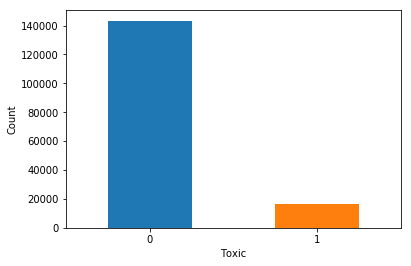

In [6]:
toxic_sum.value_counts().plot('bar')
plt.xlabel('Toxic')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.draw()

In [7]:
# Percent of comments that are toxic
np.sum(comments['is_toxic'])/comments.shape[0] * 100

10.167887648758233

From the histogram, only about 10% of the comments are toxic. This is a relatively severe imbalance that needs to be taken into account when training our classifiers.

As a final preprocessing step, let's clean up the comments by removing any special and newline characters, as well as numbers.

In [8]:
to_remove = '[' + string.punctuation + '1234567890' + ']'

In [9]:
# Remove special characters and replace newline with space
comments['comment_text'] = comments['comment_text'].apply(lambda x: re.sub(to_remove,'',x).replace('\n',' '))

Finally, it will be helpful to have a function that prints the constituent parts and common metrics from the confusion matrix (true/false positives/negatives, accuracy, precision, and recall) to help evaluate the effectiveness of our classifiers.

In [10]:
def printMetrics(pred,true):
    cm = confusion_matrix(true,pred)
    tn, fp, fn, tp = cm.ravel()
    print('True negatives: %i' % tn)
    print('False positives: %i' % fp)
    print('False negatives: %i' % fn)
    print('True positives: %i' % tp)
    acc = np.sum(np.diag(cm))/np.sum(cm)
    print('Accuracy: %4.2f' % acc)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    print('Precision: %4.2f' % precision)
    print('Recall: %4.2f' % recall)

## Multinomial Naive Bayes

Our first approach will be to use a multinomial naive Bayes model to predict whether a comment is toxic or not. This approach uses Bayes theorem and what is known as the 'bag of words' approach, where the words within a comment are considered independent of one another. Specifically, each word within a comment is given a probability of toxicity based on a set of comments used to train the model. Then, each review within a separate test set is assigned a probability of being toxic vs non-toxic based on the words it contains. The class with the highest probability determines the label assigned to the comment.

First, let's randomly split the data into training and testing sets (70% and 30%, respectively).

In [11]:
# Create separate training/testing sets
x_train, x_test, y_train, y_test = model_selection.train_test_split(comments['comment_text'], comments['is_toxic'], test_size=0.3, random_state=327)

Next, let's create a pipeline to assist in creating our model. First, we'll use a count vectorizer to create a dictionary of key/value pairs of the count for each unique word (each word is a key, and the value is the number of times the word appears). Next, we'll give each word a tf-idf (term frequency, inverse document frequency) score, which is highest for words that appear frequently in only a few comments (potential good indicators of toxicity, given the rarity of toxic comments). Finally, we'll use the tf-idf scored training dataset through a multinomial naive Bayes classifier.

In [12]:
comment_clf = Pipeline([('vect', CountVectorizer()), 
                       ('tf', TfidfTransformer()), 
                       ('clf', MultinomialNB())])

Now that we have our pipeline, let's run the training dataset through it.

In [13]:
comment_clf.fit(x_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

Now, we can predict the toxicity of our test dataset and view the relevant metrics.

In [14]:
y_pred = comment_clf.predict(x_test)

In [15]:
printMetrics(y_pred,y_test)

True negatives: 42937
False positives: 2
False negatives: 4187
True positives: 746
Accuracy: 0.91
Precision: 1.00
Recall: 0.15


At first glance, an accuracy of 91% seems impressive. However, recall that our class data set is imbalanced (roughly 90% of comments are non-toxic), so this accuracy could be achieved by simply classifying every comment as non-toxic, which is not useful at all. The most important quantities for us are the true positives (toxic comments classified as such), and false negatives (comments that we said were non-toxic but were actually toxic). If our ultimate goal is to remove toxic messages, the false negative count indicates the number that 'slipped through' our sensors. 

With this in mind, the most relevant metric for us is the recall, also known as the sensitivity or true positive rate. This metric gives the ratio of true positives to the sum of true positives and false negatives. In other words, what percentage of toxic comments did we correctly classify? The answer is only 15%! This result is typical when dealing with an imbalanced data set, and one of the easiest ways to help our classifier is to randomly upsample the minority class (in this case, artificially create more toxic comments so that the numbers are balanced).

## Multinomial Naive Bayes (Upsampled)

Let's randomly sample from the toxic comments (with replacement!), retrain our classifier, and recalculate the performance on our test dataset.

In [16]:
# Try upsampling minority class
idx_clean = np.where(y_train == 0)[0]
idx_toxic = np.where(y_train == 1)[0]

In [18]:
idx_toxic_upsampled = np.random.choice(idx_toxic, size=len(idx_clean), replace=True)

100407


In [19]:
# Combine clean labels and upsample labels
x_train_upsampled = pd.concat([x_train.iloc[idx_clean], x_train.iloc[idx_toxic_upsampled]])
y_train_upsampled = pd.concat([y_train.iloc[idx_clean], y_train.iloc[idx_toxic_upsampled]])

In [20]:
comment_clf.fit(x_train_upsampled, y_train_upsampled)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [21]:
y_pred = comment_clf.predict(x_test)

In [23]:
printMetrics(y_pred,y_test)

True negatives: 38798
False positives: 4141
False negatives: 762
True positives: 4171
Accuracy: 0.90
Precision: 0.50
Recall: 0.85


This result is much more promising, although the improved performance came at a cost. Our accuracy is still around 90%, but our precision dropped from 100% to 50%. Precision helps us answer the question: How many comments that we flagged as toxic were actually toxic? The answer here is about 50%, and the drop in precision means we mistakenly flagged many more non-toxic comments as toxic, so they would be erroneously removed from whatever forum we were monitoring. However, if our ultimate goal is to remove toxic comments, this tradeoff may be worth it, as we are now correctly identifying 85% of all toxic comments, versus only 15% before.

## Neural Network (Keras)

Next, let's try a deep learning approach on the same binary classification problem using Keras. First, we need to create a unique list of all words, as these will be used to build tokenized comments, where each word is replaced by a unique integer.

In [11]:
# Convert comments into tokenized vectors
# Requires vocabulary dictionary with key = word, value = index
word_set = set()
parsed_comments = []
comment_length = []
for comment in comments['comment_text']:
    words = comment.split()
    for word in words:
        word_set.add(word)
    parsed_comments.append(words)
    comment_length.append(len(words))
print(len(word_set))

278275


There are just under 280,000 unique words among the nearly 160,000 comments. Let's take a look at the distribution of comment lengths, as this will be a parameter in our neural network.

In [25]:
pd.Series(comment_length).describe()

count    159571.000000
mean         65.591035
std          97.529897
min           0.000000
25%          16.000000
50%          35.000000
75%          73.000000
max        1403.000000
dtype: float64

From the plot below, the distribution is heavily right skewed. This is not surprising, as most comments are made up of only 2 or 3 sentences. As the 75th percentile is only 73 words, it is safe to say that most comments are under 100 words, and we will truncate all comments to this length when training our network. Hopefully we can infer the sentiment using only the first 100 words of the longer comments.

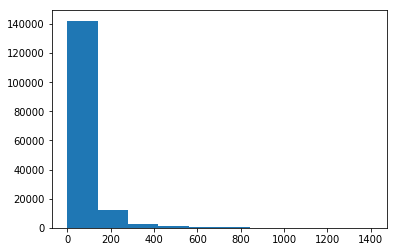

In [26]:
plt.hist(comment_length)
plt.draw()

Next, we need to create a dictionary that maps all words to a unique integer, and convert all comments to their tokenized equivalents.

In [12]:
# Convert words to word-to-index dictionary
word_to_index = {w: i+1 for i,w in enumerate(word_set)}

In [13]:
# Convert parsed comments to tokens
tokenized_comments = [[word_to_index[w] for w in s] for s in parsed_comments]

Here's an example of a tokenized comment.

In [14]:
print(tokenized_comments[0])

[133352, 223839, 227171, 235127, 251703, 39842, 52779, 199597, 98259, 110495, 12294, 116653, 74053, 248840, 126562, 28396, 106848, 255913, 141650, 267198, 128844, 31850, 61957, 104400, 41595, 188164, 155835, 13310, 198592, 75932, 275767, 215648, 139807, 227171, 73926, 104202, 227171, 29752, 227716, 179621, 238463, 114618, 41277]


Next, we need to randomly split our data into a training and testing set.

In [15]:
# Shuffle row indices for random split
idx = list(range(len(tokenized_comments)))
np.random.shuffle(idx)

In [16]:
# Split random indices between training and testing
train_frac = 0.7
split_index = round(len(idx)*train_frac)
train_ind = idx[:split_index]
test_ind = idx[split_index:]

In [17]:
# Create train set
x_train = [tokenized_comments[i] for i in train_ind]
y_train = [comments['is_toxic'].iloc[i] for i in train_ind]
# Create test set
x_test = [tokenized_comments[i] for i in test_ind]
y_test = [comments['is_toxic'].iloc[i] for i in test_ind]

Since our network requires all inputs to be of equal length, we'll truncate all comments to 100 words, and pad any necessary spaces with zeros.

In [19]:
# Pad sequences to turn comments into tensors
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=100)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=100)

In [20]:
y_train = np.array(y_train)
y_test = np.array(y_test)

Finally, we're ready to train our model. We'll use a densely connected network, with 8-dimensional embeddings for our vocabulary, and two fully connected layers with 64 nodes each. Since this is a binary classification problem, the output layer will be a single node with sigmoid activation (which forces the output to be between 0 and 1. This will be interpreted as the probability of a comment being toxic.

After our model is trained, we'll plot the accuracy and loss as a function of the epoch.

In [42]:
# Create model
vocab_size = len(word_set)
model = Sequential()
model.add(Embedding(vocab_size+1, 8, input_length=100))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 8)            2226208   
_________________________________________________________________
flatten_2 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                51264     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 2,281,697
Trainable params: 2,281,697
Non-trainable params: 0
_________________________________________________________________


In [43]:
history = model.fit(x_train, y_train,
                   epochs=10,
                   batch_size=32,
                   validation_split=0.2)

Train on 89360 samples, validate on 22340 samples
Epoch 1/10
89360/89360 [==============================] - 39s 434us/step - loss: 0.2043 - acc: 0.9274 - val_loss: 0.1696 - val_acc: 0.9397
Epoch 2/10
89360/89360 [==============================] - 39s 439us/step - loss: 0.1650 - acc: 0.9425 - val_loss: 0.1624 - val_acc: 0.9416
Epoch 3/10
89360/89360 [==============================] - 39s 438us/step - loss: 0.1514 - acc: 0.9485 - val_loss: 0.1772 - val_acc: 0.9434
Epoch 4/10
89360/89360 [==============================] - 37s 410us/step - loss: 0.1433 - acc: 0.9522 - val_loss: 0.1644 - val_acc: 0.9457
Epoch 5/10
89360/89360 [==============================] - 35s 389us/step - loss: 0.1345 - acc: 0.9569 - val_loss: 0.1816 - val_acc: 0.9459
Epoch 6/10
89360/89360 [==============================] - 38s 423us/step - loss: 0.1291 - acc: 0.9592 - val_loss: 0.2086 - val_acc: 0.9378
Epoch 7/10
89360/89360 [==============================] - 33s 375us/step - loss: 0.1235 - acc: 0.9615 - val_loss: 0.

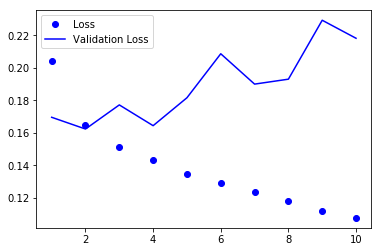

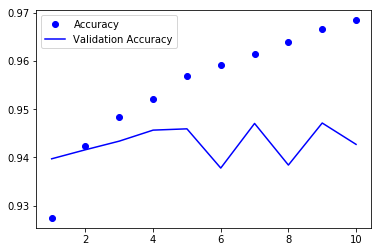

In [44]:
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(accuracy)+1)
plt.plot(epochs,loss,'bo',label='Loss')
plt.plot(epochs,val_loss,'b',label='Validation Loss')
plt.legend()
plt.show()

plt.clf()
plt.plot(epochs,accuracy,'bo',label='Accuracy')
plt.plot(epochs,val_accuracy,'b',label='Validation Accuracy')
plt.legend()
plt.show()

Our model begins to overfit after approximately four epochs (signified by the validation loss increasing as the training loss continues to decrease). Let's build another model and train for just four epochs.

In [45]:
# Create model
vocab_size = len(word_set)
model = Sequential()
model.add(Embedding(vocab_size+1, 8, input_length=100))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 8)            2226208   
_________________________________________________________________
flatten_3 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                51264     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 2,281,697
Trainable params: 2,281,697
Non-trainable params: 0
_________________________________________________________________


In [46]:
history = model.fit(x_train, y_train,
                   epochs=4,
                   batch_size=32,
                   validation_split=0.2)

Train on 89360 samples, validate on 22340 samples
Epoch 1/4
89360/89360 [==============================] - 33s 364us/step - loss: 0.1995 - acc: 0.9302 - val_loss: 0.1713 - val_acc: 0.9388
Epoch 2/4
89360/89360 [==============================] - 33s 366us/step - loss: 0.1590 - acc: 0.9459 - val_loss: 0.2060 - val_acc: 0.9337
Epoch 3/4
89360/89360 [==============================] - 33s 366us/step - loss: 0.1484 - acc: 0.9507 - val_loss: 0.1605 - val_acc: 0.9470
Epoch 4/4
89360/89360 [==============================] - 33s 372us/step - loss: 0.1412 - acc: 0.9546 - val_loss: 0.1717 - val_acc: 0.9465


Now, let's use our model to predict whether comments from the test set are toxic or not.

In [47]:
y_pred = model.predict_classes(x_test)

In [48]:
printMetrics(y_pred,y_test)

True negatives: 42482
False positives: 571
False negatives: 1974
True positives: 2844
Accuracy: 0.95
Precision: 0.83
Recall: 0.59


Our deep learning model suffers from the same problem as our naive Bayes model, namely that the accuracy is high but the recall (what we really care about) is too low. The baseline here is better compared to the naive Bayes model (59% versus 15%), but it is not nearly good enough.

Since our classes are quite imbalanced, one easy way to improve things is to add class weights, which will give more focus to the minority class.

## Neural Network (Keras) with Class Weights

Since there are roughly 10 non-toxic comments for every toxic one, let's give the toxic class a weight of 10, and the non-toxic class a weight of 1. With this done, let's rebuild our model and check the results. Note that we had to decrease the learning rate slightly (from 1e-3 to 1e-4) to help the model converge.

In [43]:
# Try changing class weights to give more attention to positive instances (toxic comments)
class_weight = {0:1, 1:10}

In [97]:
# Create model
rms = optimizers.RMSprop(lr=1e-4)
vocab_size = len(word_set)
model = Sequential()
model.add(Embedding(vocab_size+1, 8, input_length=100))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=rms, loss='binary_crossentropy', metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 100, 8)            2226208   
_________________________________________________________________
flatten_19 (Flatten)         (None, 800)               0         
_________________________________________________________________
dense_65 (Dense)             (None, 64)                51264     
_________________________________________________________________
dense_66 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_67 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_68 (Dense)             (None, 1)                 65        
Total params: 2,285,857
Trainable params: 2,285,857
Non-trainable params: 0
_________________________________________________________________


In [98]:
history = model.fit(x_train, y_train,
                   epochs=20,
                   batch_size=32,
                   validation_split=0.2,
                   class_weight=class_weight)

Train on 89360 samples, validate on 22340 samples
Epoch 1/20
89360/89360 [==============================] - 35s 397us/step - loss: 1.1451 - acc: 0.6105 - val_loss: 0.8580 - val_acc: 0.7816
Epoch 2/20
89360/89360 [==============================] - 34s 382us/step - loss: 0.7766 - acc: 0.8377 - val_loss: 0.7500 - val_acc: 0.8261
Epoch 3/20
89360/89360 [==============================] - 35s 392us/step - loss: 0.7077 - acc: 0.8536 - val_loss: 0.7363 - val_acc: 0.8749
Epoch 4/20
89360/89360 [==============================] - 35s 392us/step - loss: 0.6862 - acc: 0.8566 - val_loss: 0.7152 - val_acc: 0.8482
Epoch 5/20
89360/89360 [==============================] - 36s 404us/step - loss: 0.6724 - acc: 0.8581 - val_loss: 0.7143 - val_acc: 0.8165
Epoch 6/20
89360/89360 [==============================] - 35s 387us/step - loss: 0.6638 - acc: 0.8613 - val_loss: 0.7139 - val_acc: 0.8578
Epoch 7/20
89360/89360 [==============================] - 35s 392us/step - loss: 0.6535 - acc: 0.8642 - val_loss: 0.

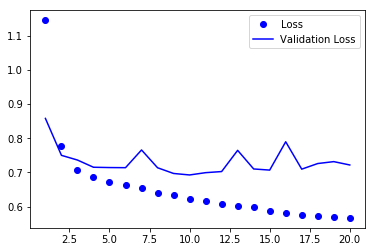

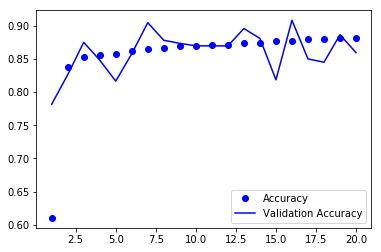

In [99]:
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(accuracy)+1)
plt.plot(epochs,loss,'bo',label='Loss')
plt.plot(epochs,val_loss,'b',label='Validation Loss')
plt.legend()
plt.show()

plt.clf()
plt.plot(epochs,accuracy,'bo',label='Accuracy')
plt.plot(epochs,val_accuracy,'b',label='Validation Accuracy')
plt.legend()
plt.show()

Once again, the model begins to overfit, this time after roughly 10 epochs. Let's build a second model as before, and check the results on the test set.

In [100]:
# Create model
model = Sequential()
model.add(Embedding(vocab_size+1, 8, input_length=100))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=rms, loss='binary_crossentropy', metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 100, 8)            2226208   
_________________________________________________________________
flatten_20 (Flatten)         (None, 800)               0         
_________________________________________________________________
dense_69 (Dense)             (None, 64)                51264     
_________________________________________________________________
dense_70 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_71 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_72 (Dense)             (None, 1)                 65        
Total params: 2,285,857
Trainable params: 2,285,857
Non-trainable params: 0
_________________________________________________________________


In [101]:
history = model.fit(x_train, y_train,
                   epochs=10,
                   batch_size=32,
                   validation_split=0.2,
                   class_weight=class_weight)

Train on 89360 samples, validate on 22340 samples
Epoch 1/10
89360/89360 [==============================] - 35s 394us/step - loss: 1.1623 - acc: 0.6067 - val_loss: 0.8716 - val_acc: 0.7675
Epoch 2/10
89360/89360 [==============================] - 34s 377us/step - loss: 0.7905 - acc: 0.8337 - val_loss: 0.7764 - val_acc: 0.8758
Epoch 3/10
89360/89360 [==============================] - 34s 384us/step - loss: 0.7175 - acc: 0.8528 - val_loss: 0.7330 - val_acc: 0.8603
Epoch 4/10
89360/89360 [==============================] - 35s 389us/step - loss: 0.6884 - acc: 0.8550 - val_loss: 0.7263 - val_acc: 0.8697
Epoch 5/10
89360/89360 [==============================] - 34s 381us/step - loss: 0.6740 - acc: 0.8561 - val_loss: 0.7201 - val_acc: 0.8159
Epoch 6/10
89360/89360 [==============================] - 33s 368us/step - loss: 0.6664 - acc: 0.8587 - val_loss: 0.7169 - val_acc: 0.8735
Epoch 7/10
89360/89360 [==============================] - 34s 381us/step - loss: 0.6605 - acc: 0.8610 - val_loss: 0.

In [102]:
y_pred = model.predict_classes(x_test)

In [103]:
printMetrics(y_pred,y_test)

True negatives: 35177
False positives: 7876
False negatives: 743
True positives: 4075
Accuracy: 0.82
Precision: 0.34
Recall: 0.85


The results have improved significantly, as the recall is up to 85%, which is on par with our naive Bayes model. However, the precision is quite a bit lower, which means we flagged more clean comments as toxic.

Perhaps with more focused hyperparameter tuning, and a potential architecture change (trying a recurrent neural network instead of a densely connected one), we could improve these results. However, at first glance, the naive Bayes model would be the model of choice for this simple, binary sentiment analysis formulation. The overhead and time to train is significantly lower than that of the neural network, and it does a better job.

That being said, the next exercise is one that is very well suited to a neural network, and that is a multilabel, multiclass formulation of the problem.

## Neural Network (Keras) with Multiclass, Multilabel Formulation

Recall that the original dataset contained additional labels for the type of toxicity (hate speech, insult, etc.). Let's see if we can build a network to predict the associated labels. Rather than a binary classification problem, this is now a multilabel, multiclass problem.

We'll start by building our training and testing sets, this time using all of the labels for each comment.

In [23]:
# Create train set
x_train = [tokenized_comments[i] for i in train_ind]
y_train = [comments.iloc[i,2:8] for i in train_ind]
# Create test set
x_test = [tokenized_comments[i] for i in test_ind]
y_test = [comments.iloc[i,2:8] for i in test_ind]

In [24]:
# Pad sequences to turn comments into tensors
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=100)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=100)

In [25]:
y_train = np.array(y_train)
y_test = np.array(y_test)

The major change to our network architecture will be that the last layer contains 6 nodes (one for each label). The activation function is still sigmoid (so each node will have an independent range of 0-1), and the loss is still binary crossentropy.

In [65]:
# Create model with 6 node sigmoid output layer
rms = optimizers.RMSprop(lr=1e-4)
vocab_size = len(word_set)
model = Sequential()
model.add(Embedding(vocab_size+1, 16, input_length=100))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(6, activation='sigmoid'))
model.compile(optimizer=rms, loss='binary_crossentropy', metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 16)           4452416   
_________________________________________________________________
flatten_3 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                102464    
_________________________________________________________________
dense_11 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_12 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_14 (Dense)             (None, 6)                 390       
Total para

In [66]:
history = model.fit(x_train, y_train,
                   epochs=20,
                   batch_size=32,
                   validation_split=0.2)

Train on 89360 samples, validate on 22340 samples
Epoch 1/20
89360/89360 [==============================] - 91s 1ms/step - loss: 0.1382 - acc: 0.9628 - val_loss: 0.0900 - val_acc: 0.9693
Epoch 2/20
89360/89360 [==============================] - 90s 1ms/step - loss: 0.0868 - acc: 0.9705 - val_loss: 0.0811 - val_acc: 0.9729
Epoch 3/20
89360/89360 [==============================] - 99s 1ms/step - loss: 0.0799 - acc: 0.9729 - val_loss: 0.0789 - val_acc: 0.9736
Epoch 4/20
89360/89360 [==============================] - 104s 1ms/step - loss: 0.0760 - acc: 0.9740 - val_loss: 0.0754 - val_acc: 0.9749
Epoch 5/20
89360/89360 [==============================] - 90s 1ms/step - loss: 0.0736 - acc: 0.9750 - val_loss: 0.0745 - val_acc: 0.9754
Epoch 6/20
89360/89360 [==============================] - 77s 858us/step - loss: 0.0716 - acc: 0.9754 - val_loss: 0.0733 - val_acc: 0.9757
Epoch 7/20
89360/89360 [==============================] - 76s 848us/step - loss: 0.0694 - acc: 0.9764 - val_loss: 0.0717 - va

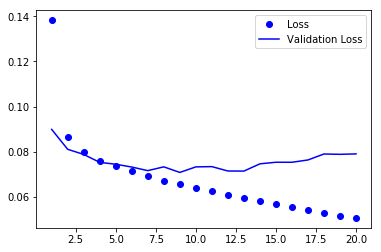

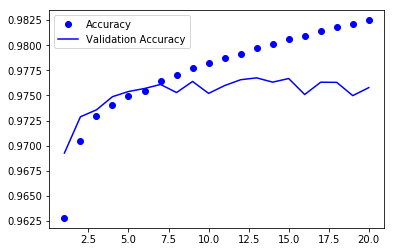

In [67]:
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(accuracy)+1)
plt.plot(epochs,loss,'bo',label='Loss')
plt.plot(epochs,val_loss,'b',label='Validation Loss')
plt.legend()
plt.show()

plt.clf()
plt.plot(epochs,accuracy,'bo',label='Accuracy')
plt.plot(epochs,val_accuracy,'b',label='Validation Accuracy')
plt.legend()
plt.show()

As before, our model begins to overfit, this time after 13 epochs. Let's build a second model and check the results using a few techniques (it is not as simple as before, since now we have a vector output).

In [68]:
# Create model with 6 node sigmoid output layer
rms = optimizers.RMSprop(lr=1e-4)
vocab_size = len(word_set)
model = Sequential()
model.add(Embedding(vocab_size+1, 16, input_length=100))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(6, activation='sigmoid'))
model.compile(optimizer=rms, loss='binary_crossentropy', metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 16)           4452416   
_________________________________________________________________
flatten_4 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 64)                102464    
_________________________________________________________________
dense_16 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_17 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_18 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_19 (Dense)             (None, 6)                 390       
Total para

In [69]:
history = model.fit(x_train, y_train,
                   epochs=13,
                   batch_size=32,
                   validation_split=0.2)

Train on 89360 samples, validate on 22340 samples
Epoch 1/13
89360/89360 [==============================] - 83s 923us/step - loss: 0.1400 - acc: 0.9605 - val_loss: 0.0938 - val_acc: 0.9664
Epoch 2/13
89360/89360 [==============================] - 70s 788us/step - loss: 0.0894 - acc: 0.9696 - val_loss: 0.0847 - val_acc: 0.9717
Epoch 3/13
89360/89360 [==============================] - 70s 785us/step - loss: 0.0826 - acc: 0.9721 - val_loss: 0.0798 - val_acc: 0.9734
Epoch 4/13
89360/89360 [==============================] - 70s 789us/step - loss: 0.0781 - acc: 0.9734 - val_loss: 0.0768 - val_acc: 0.9740
Epoch 5/13
89360/89360 [==============================] - 383s 4ms/step - loss: 0.0745 - acc: 0.9745 - val_loss: 0.0788 - val_acc: 0.9740
Epoch 6/13
89360/89360 [==============================] - 72s 810us/step - loss: 0.0719 - acc: 0.9757 - val_loss: 0.0738 - val_acc: 0.9754
Epoch 7/13
89360/89360 [==============================] - 73s 822us/step - loss: 0.0699 - acc: 0.9764 - val_loss: 0.0

In [70]:
y_pred = model.predict(x_test)

Now, our predictions are the probability of each label being assigned to a comment. Let's look at an example.

In [71]:
y_pred[10]

array([1.3236671e-03, 2.6692546e-09, 3.7316061e-04, 5.6367964e-09,
       1.6937651e-04, 2.2211088e-06], dtype=float32)

One metric we can compute is the average precision score, which ranges from 0-1. Our value of 0.99 is quite high, meaning we didn't flag many non-toxic comments incorrectly.

In [72]:
label_ranking_average_precision_score(y_test,y_pred)

0.9943331383649118

Let's take a look at a random sample of results, comparing the true and predicted labels. In addition, we'll print the norm of the difference between the vectors. This gives an indication of how far apart the labels are.

In [116]:
toxic = list(np.where(np.sum(y_test,axis=1))[0])

In [152]:
rand_ind = random.sample(toxic,10)

In [153]:
for ind in rand_ind:
    pred = np.round(y_pred[ind]).astype(int)
    actual = y_test[ind]
    norm = np.linalg.norm(pred-actual)
    print('Predicted: %s, Actual: %s, Norm: %f' % (pred,actual,norm))

Predicted: [1 0 1 0 1 0], Actual: [1 0 1 0 1 0], Norm: 0.000000
Predicted: [1 0 0 0 0 0], Actual: [1 0 0 0 0 0], Norm: 0.000000
Predicted: [1 0 1 0 1 0], Actual: [1 0 0 0 0 0], Norm: 1.414214
Predicted: [1 0 1 0 1 0], Actual: [1 1 1 1 1 1], Norm: 1.732051
Predicted: [1 0 0 0 0 0], Actual: [1 0 1 0 1 1], Norm: 1.732051
Predicted: [0 0 0 0 0 0], Actual: [1 0 0 0 0 0], Norm: 1.000000
Predicted: [1 0 1 0 1 0], Actual: [1 0 0 0 0 0], Norm: 1.414214
Predicted: [1 0 1 0 1 0], Actual: [1 0 0 0 1 0], Norm: 1.000000
Predicted: [1 0 0 0 0 0], Actual: [1 0 0 0 0 0], Norm: 0.000000
Predicted: [1 0 1 0 1 0], Actual: [1 0 1 0 0 0], Norm: 1.000000


Note that a few labels are exactly right, some had one mislabel, and a few had two or three. Let's plot these differences, to see the distribution of mislabels. Note that we don't know if the placement of labels is correct, only the number. Still, this gives us a general indication of how closely the labels align.

In [171]:
predict_sum = np.sum(np.round(y_pred),axis=1)
actual_sum = np.sum(y_test,axis=1)

In [207]:
diff = np.absolute(predict_sum-actual_sum).astype(float)

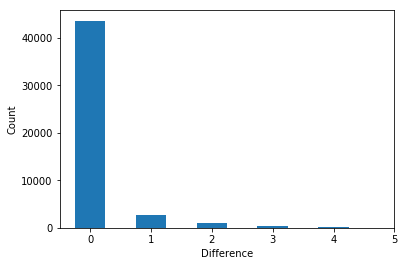

In [211]:
plt.hist(diff,align='left')
plt.xlabel('Difference')
plt.ylabel('Count')
plt.draw()

Note that of the roughly 47,000 samples, most had the labels exactly right, around 2,000 were off by one label, and only a few hundred were off by more.

As a final check, let's see how many toxic comments received at least one toxic label.

In [217]:
predict_toxic = predict_sum > 0
predict_toxic = predict_toxic.astype(int)

In [216]:
actual_toxic = actual_sum > 0
actual_toxic = actual_toxic.astype(int)

In [218]:
printMetrics(predict_toxic,actual_toxic)

True negatives: 42626
False positives: 477
False negatives: 2452
True positives: 2316
Accuracy: 0.94
Precision: 0.83
Recall: 0.49


It looks like we only caught about half of the toxic comments. Since it's more difficult to assign class weights in the multilabel case, let's try upsampling the toxic comments, like we did in the naive Bayes formulation.

## Neural Network (Keras) with Multiclass, Multilabel Formulation, Upsampled

As in the naive Bayes case, let's try upsampling the toxic comments (with replacement), and see if that helps our model.

In [79]:
y_train_sum = np.sum(y_train,axis=1)

In [80]:
# Try upsampling minority class
idx_clean = np.where(y_train_sum == 0)[0]
idx_toxic = np.where(y_train_sum > 0)[0]

In [81]:
idx_toxic_upsampled = np.random.choice(idx_toxic, size=len(idx_clean), replace=True)

In [82]:
# Combine clean labels and upsample labels
x_train_upsampled = np.concatenate([x_train[idx_clean], x_train[idx_toxic_upsampled]])
y_train_upsampled = np.concatenate([y_train[idx_clean], y_train[idx_toxic_upsampled]])

In [86]:
# Create model with 6 node sigmoid output layer
rms = optimizers.RMSprop(lr=1e-4)
vocab_size = len(word_set)
model = Sequential()
model.add(Embedding(vocab_size+1, 16, input_length=100))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(6, activation='sigmoid'))
model.compile(optimizer=rms, loss='binary_crossentropy', metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 100, 16)           4452416   
_________________________________________________________________
flatten_22 (Flatten)         (None, 1600)              0         
_________________________________________________________________
dense_96 (Dense)             (None, 64)                102464    
_________________________________________________________________
dense_97 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_98 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_99 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_100 (Dense)            (None, 6)                 390       
Total para

In [87]:
history = model.fit(x_train_upsampled, y_train_upsampled,
                   epochs=40,
                   batch_size=64,
                   validation_split=0.2,
                   shuffle=True)

Train on 160684 samples, validate on 40172 samples
Epoch 1/40
160684/160684 [==============================] - 70s 435us/step - loss: 0.2546 - acc: 0.8992 - val_loss: 0.4192 - val_acc: 0.8207
Epoch 2/40
160684/160684 [==============================] - 65s 407us/step - loss: 0.1645 - acc: 0.9355 - val_loss: 0.3771 - val_acc: 0.8431
Epoch 3/40
160684/160684 [==============================] - 66s 411us/step - loss: 0.1426 - acc: 0.9445 - val_loss: 0.3291 - val_acc: 0.8680
Epoch 4/40
160684/160684 [==============================] - 66s 411us/step - loss: 0.1277 - acc: 0.9508 - val_loss: 0.3058 - val_acc: 0.8817
Epoch 5/40
160684/160684 [==============================] - 67s 414us/step - loss: 0.1152 - acc: 0.9561 - val_loss: 0.2770 - val_acc: 0.8933
Epoch 6/40
160684/160684 [==============================] - 67s 417us/step - loss: 0.1029 - acc: 0.9605 - val_loss: 0.2489 - val_acc: 0.9042
Epoch 7/40
160684/160684 [==============================] - 67s 419us/step - loss: 0.0905 - acc: 0.9651

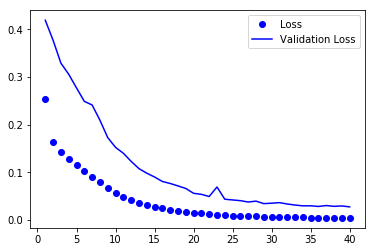

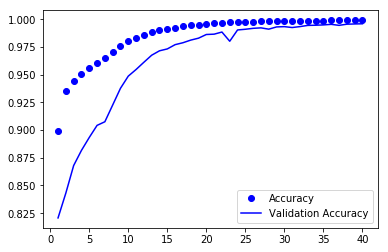

In [88]:
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(accuracy)+1)
plt.plot(epochs,loss,'bo',label='Loss')
plt.plot(epochs,val_loss,'b',label='Validation Loss')
plt.legend()
plt.show()

plt.clf()
plt.plot(epochs,accuracy,'bo',label='Accuracy')
plt.plot(epochs,val_accuracy,'b',label='Validation Accuracy')
plt.legend()
plt.show()

The model converges quite smoothly, so let's check the performance on the test set.

In [89]:
y_pred = model.predict(x_test)

In [90]:
label_ranking_average_precision_score(y_test,y_pred)

0.9833510371623746

In [92]:
toxic = list(np.where(np.sum(y_test,axis=1))[0])

In [105]:
rand_ind = random.sample(toxic,10)

In [106]:
for ind in rand_ind:
    pred = np.round(y_pred[ind]).astype(int)
    actual = y_test[ind]
    norm = np.linalg.norm(pred-actual)
    print('Predicted: %s, Actual: %s, Norm: %f' % (pred,actual,norm))

Predicted: [0 0 0 0 0 0], Actual: [1 0 1 0 1 0], Norm: 1.732051
Predicted: [1 0 1 0 1 0], Actual: [1 0 1 0 1 0], Norm: 0.000000
Predicted: [0 0 0 0 0 0], Actual: [1 0 0 0 0 0], Norm: 1.000000
Predicted: [1 1 1 0 1 0], Actual: [1 1 1 0 1 0], Norm: 0.000000
Predicted: [1 0 0 0 1 0], Actual: [1 0 1 0 1 0], Norm: 1.000000
Predicted: [0 0 0 0 0 0], Actual: [1 0 1 0 1 0], Norm: 1.732051
Predicted: [0 0 0 0 0 0], Actual: [1 0 0 0 0 0], Norm: 1.000000
Predicted: [0 0 0 0 0 0], Actual: [1 0 0 0 0 0], Norm: 1.000000
Predicted: [1 0 0 0 0 0], Actual: [1 0 0 0 0 0], Norm: 0.000000
Predicted: [1 0 0 0 1 0], Actual: [1 0 1 0 1 0], Norm: 1.000000


Once again, some labels are exactly right, some are mislabeled once, and a few are off by more. Looking at the distribution of mislabels, it appears quite similar to the previous case, before upsampling.

In [98]:
predict_sum = np.sum(np.round(y_pred),axis=1)
actual_sum = np.sum(y_test,axis=1)

In [107]:
diff = np.absolute(predict_sum-actual_sum).astype(float)

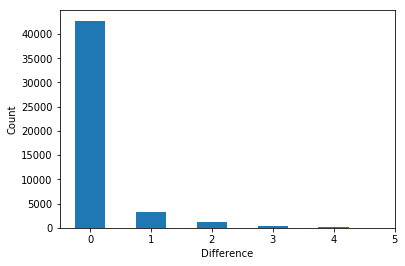

In [108]:
plt.hist(diff,align='left')
plt.xlabel('Difference')
plt.ylabel('Count')
plt.draw()

In [97]:
predict_toxic = predict_sum > 0
predict_toxic = predict_toxic.astype(int)

As a final check, let's see how many toxic comments we actually flagged.

In [99]:
actual_toxic = actual_sum > 0
actual_toxic = actual_toxic.astype(int)

In [100]:
printMetrics(predict_toxic,actual_toxic)

True negatives: 41697
False positives: 1221
False negatives: 1905
True positives: 3048
Accuracy: 0.93
Precision: 0.71
Recall: 0.62


It looks like we only caught 62% of toxic comments, which is far less than the binary case. Given the more complex nature of this problem, and the fact that knowing something about the sequence of words might help the specific labeling, one other thing to try would be a recurrent network with one or more LSTM layers. That will be tried in a future version of this writeup. For now, we explored the binary classification formulation of the problem, and found that a simple naive Bayes model worked best. Some success was achieved using the multilabel, multiclass formulation, but a more complex network architecture is probably required to achieve better performance.